<h2 style='color: orange'>Équipe: Louis & Emire</h2>

# Index

1. [Régression linéaire vs DNN](./projet_tp6_rc_dnn_louis_emire.ipynb)
2. [Régression linéaire vs Auto-Encodeur](./projet_tp6_rc_lae_louis_emire.ipynb)
3. [PCA 2D & auto-Encodeur linéaire](./projet_tp6_pca2d_lae_louis_emire.ipynb)

#### C. Démontrez qu'une PCA 2D est équivalent à la couche interne bottleneck d'Auto-Encodeur linéaire.

In [358]:
# Librairies
import torch
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from torch import nn
from scipy.stats import pearsonr
from utils.DataSet import DataSet
from collections import Counter
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from utils.random_color_generator import random_color_generator

# Adding initial project root to path

path_to_module = '../'

# Add this path to sys.path
if path_to_module not in sys.path:
    sys.path.insert(0, path_to_module)

import common.engines as engines

In [359]:
# Data importation and pre-processing

data_set = DataSet('./data/TCGA_TPM_hv_subset.h5')

figures_directory = "./figures/project"

data = data_set.get_data('data', float)

genes = data_set.get_data('cols', str)
labels = data_set.get_data('labels', str)
rows = data_set.get_data('rows', str)

labels_counter = Counter(labels)

c_type, counts = [], []

for (key_, cnt) in labels_counter.items():
    c_type.append(key_), counts.append(cnt)

tcga_abbrevs = pd.read_csv("./data/TCGA_abbrev.txt")

counts_df = pd.DataFrame(dict([("c_type", c_type), ("count",counts)]))
nsamples_ctype = pd.merge(counts_df.sort_values(["count"]), tcga_abbrevs, how = "left", left_on = "c_type", right_on ="abbrv")

ntypes = nsamples_ctype.shape[0]

colors_by_ctype = [random_color_generator() for  i in range(ntypes)]

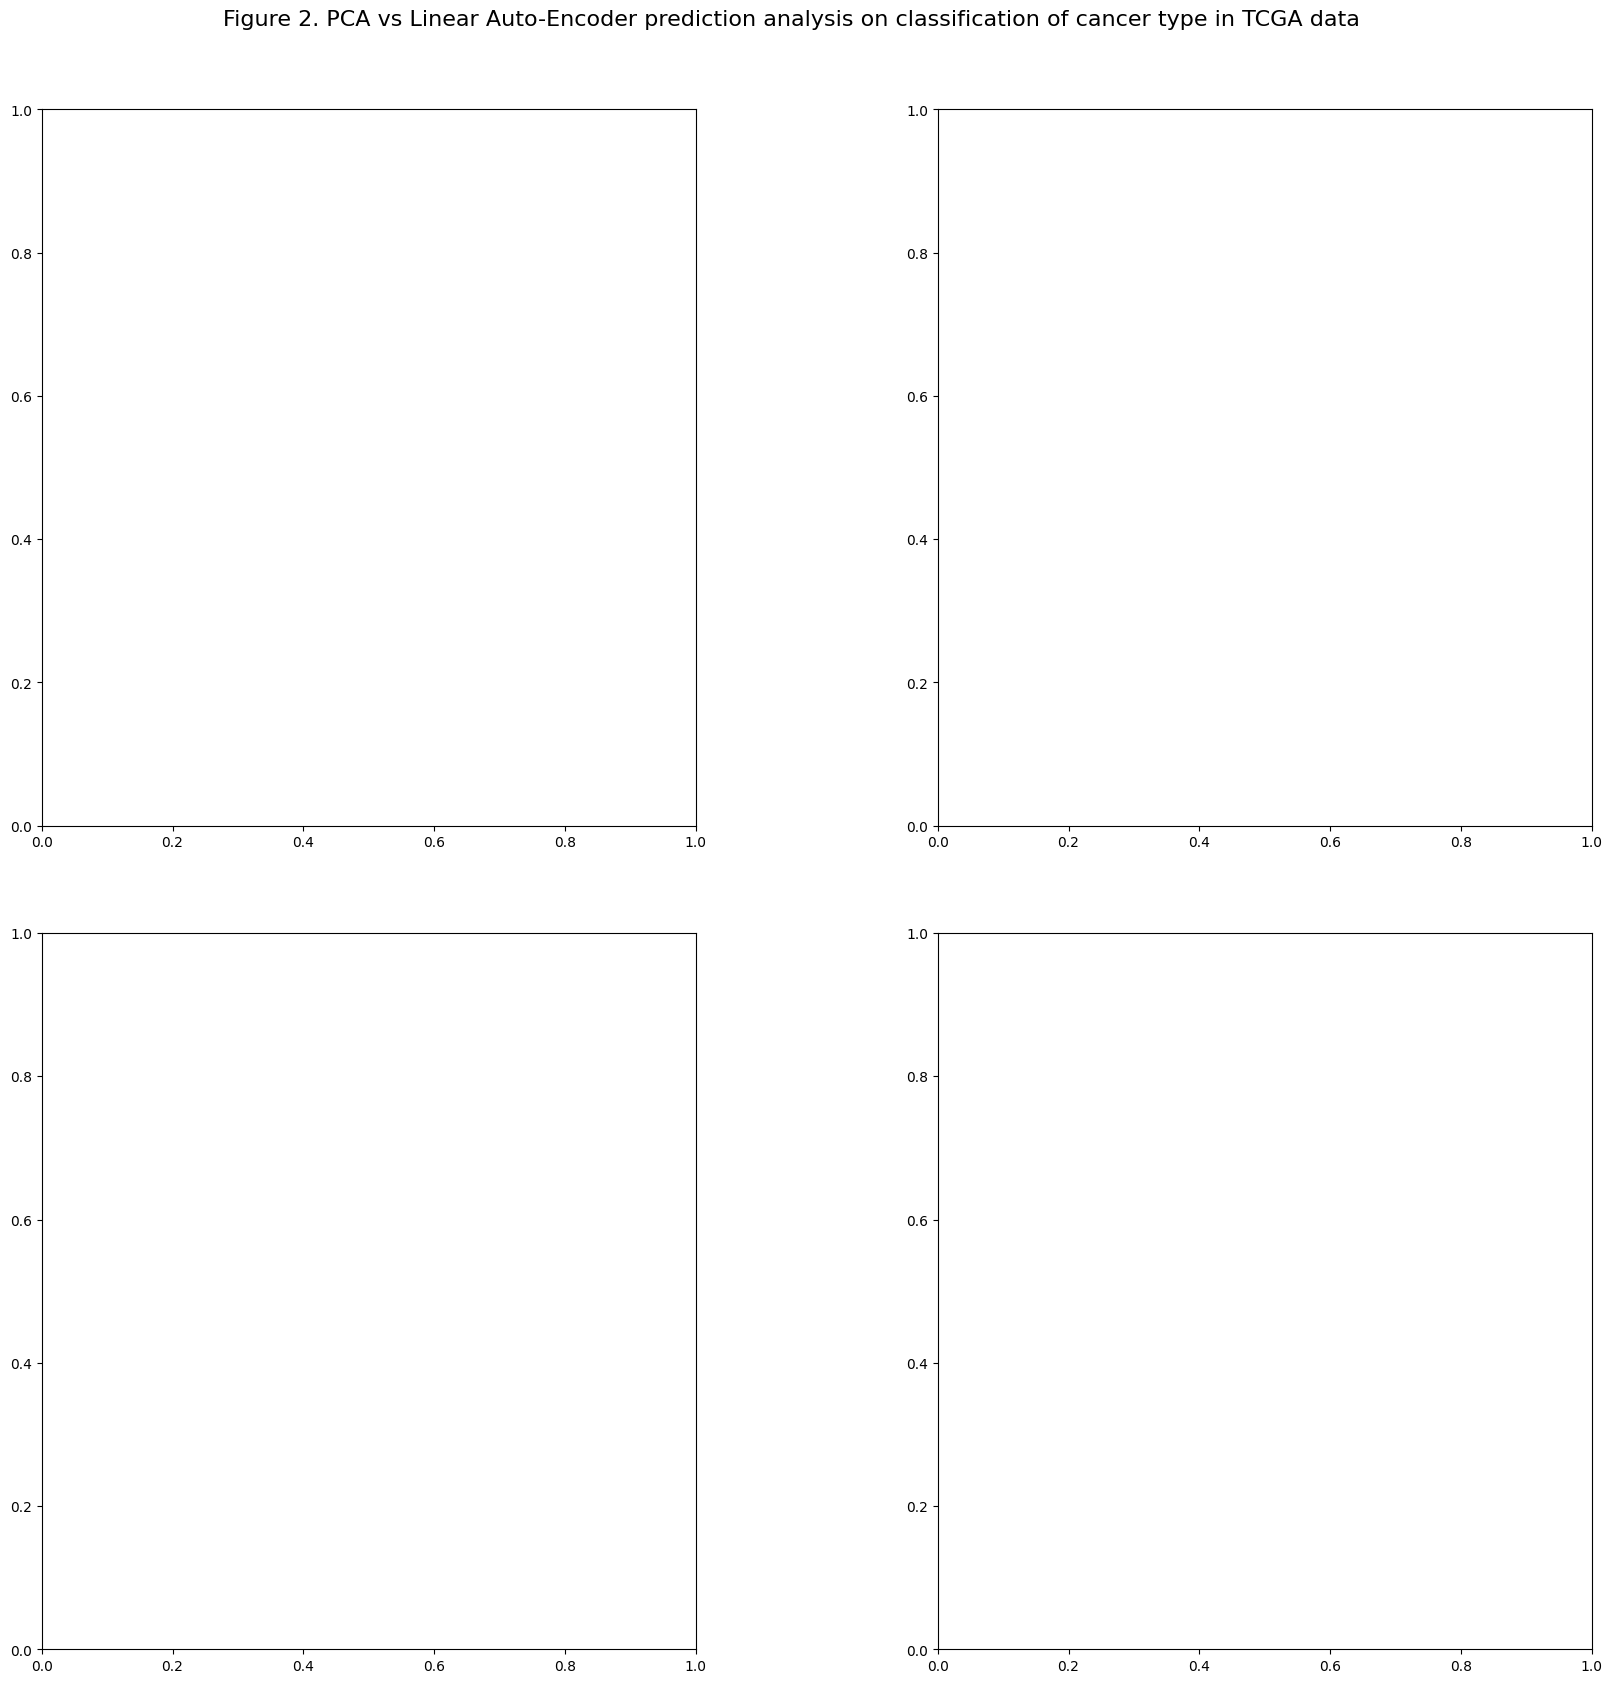

In [360]:
fig, axs = plt.subplots(2, 2, figsize = (20, 20))
fig.subplots_adjust(hspace=0.15, wspace=0.37)
fig.suptitle('Figure 2. PCA vs Linear Auto-Encoder prediction analysis on classification of cancer type in TCGA data',
              fontsize=16, y=0.93)
markers_ = np.concatenate([['o',"v","^","<",">","8","p","s","h","D","P","X"] for i in range(10)])

In [361]:
lblbin = LabelBinarizer()

targets = torch.Tensor(lblbin.fit_transform(labels))

X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(data.T), targets, test_size=0.2)

insize = X_train.shape[1]

#### PCA 2D

In [362]:
perplexity = 30
n_components = 2

pca = PCA(n_components=n_components)
pca.fit(X_train)

PCA_X_test = pca.transform(X_test)

In [363]:
y_tr_labs = lblbin.inverse_transform(Y_train.detach().numpy())
y_tst_labs = lblbin.inverse_transform(Y_test.detach().numpy())

Scatter plot

In [364]:
axs[0, 0].cla()

axs[0, 0].grid(visible=True,linestyle="--")
axs[0, 0].set_axisbelow(True)

for (i,lbl) in enumerate(np.unique(labels)):
    count_ = counts_df.loc[counts_df["c_type"] == lbl,"count"].values[0]
    tag = f"{lbl.split('-')[-1]} ({count_})"
    
    axs[0, 0].scatter(PCA_X_test[y_tst_labs ==lbl,0], 
                PCA_X_test[y_tst_labs ==lbl,1], 
                s = 12, color =colors_by_ctype[i], marker=markers_[i], label=tag)

axs[0, 0].axis("equal")
axs[0, 0].legend(bbox_to_anchor=(1, 1), fontsize=9, title="Cancer subtypes\n(Number of patients)")
axs[0, 0].set_xlabel("PCA 1", fontsize=12)
axs[0, 0].set_ylabel("PCA 2", fontsize=12)
axs[0, 0].set_title(f"2.a PCA prediction of gene expression on test set\nPerplexity = {perplexity} ; Components = {n_components}", fontsize=14)

Text(0.5, 1.0, '2.a PCA prediction of gene expression on test set\nPerplexity = 30 ; Components = 2')

In [365]:
cum_var = np.cumsum(pca.explained_variance_ratio_)
cum_var = [round(var * 100, 2) for var in cum_var]
tev = round(cum_var[-1], 2)

axs[1, 0].cla()
# Plotting the cumulative variance
axs[1, 0].plot(cum_var, marker='o', label='Cumulative Variance')

# Adding a bar for each component's explained variance
for i in range(len(pca.explained_variance_ratio_)):
    axs[1, 0].bar(i, round(pca.explained_variance_ratio_[i] * 100, 2), alpha=0.4, label=f'Component {i+1}')

# Setting the x-axis ticks
axs[1, 0].set_xticks(ticks=np.arange(len(cum_var)), labels=np.arange(1, len(cum_var) + 1))
axs[1, 0].set_xlabel('Number of Components', fontsize=12)
axs[1, 0].set_ylabel('Explained Variance (%)', fontsize=12)
axs[1, 0].set_title(f'2.b PCA variance explained by components on test set\n Total explained variance :  {tev}%', fontsize=14)
axs[1, 0].grid(True)
axs[1, 0].legend()

#### Auto-Endcoder

In [366]:
### fonction d'initialisation du reseau
def linear_auto_encoder(insize, outsize, bnsize, width=500):
    model = nn.Sequential(
    nn.Linear(insize,width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, bnsize, bias = False), 
    nn.Linear(bnsize, width, bias = False),
    nn.Linear(width, width, bias = False),
    nn.Linear(width, outsize, bias = False))
    return model, model[0:3]


def train_linear_auto_encoder(insize, bnsize, X_train, X_test, nepochs = 100, printstep=10, wd = 1e-3, lr = 1e-4):
    DNN, encoder = linear_auto_encoder(insize, insize, bnsize )
    optimizer = torch.optim.Adam(DNN.parameters(), lr = lr)
    tr_losses, tst_losses, tr_accs, tst_accs = [],[],[],[]
    for i in range(nepochs):
        optimizer.zero_grad() # required
        y_tr_out = DNN(X_train) # feed forward
        y_tst_out = DNN(X_test)
        tr_loss = nn.functional.mse_loss(y_tr_out, X_train) # loss computation
        tst_loss = nn.functional.mse_loss(y_tst_out, X_test) # Softmax -> NLL
        
        tr_acc = pearsonr(y_tr_out.flatten().detach().numpy(), X_train.flatten().detach().numpy()).statistic # Pearson corr. coeff
        tst_acc = pearsonr(y_tst_out.flatten().detach().numpy(), X_test.flatten().detach().numpy()).statistic
            
        if i % printstep == 0 or i+1 == nepochs :
            print(f"Loss {i} Train - loss : {round(float(tr_loss),3)} - acc : {round(float(tr_acc),3)} Test acc : {round(tst_acc,3)}")
        tr_loss.backward() # back prop
        optimizer.step() # optimizer update
        [tr_losses.append(float(tr_loss)), tst_losses.append(float(tst_loss)), tr_accs.append(tr_acc), tst_accs.append(tst_acc)]
    return DNN, np.array(tr_losses), np.array(tst_losses), np.array(tr_accs), np.array(tst_accs)

In [367]:
nepochs = 100

lr = 1e-4

bottleneck = 2

lblbin = LabelBinarizer()

targets = torch.Tensor(lblbin.fit_transform(labels))

X_train, X_test, Y_train, Y_test = train_test_split(torch.Tensor(data.T), targets, test_size=0.2)

insize = X_train.shape[1]

y_tr_labs = lblbin.inverse_transform(Y_train.detach().numpy())

y_tst_labs = lblbin.inverse_transform(Y_test.detach().numpy())

mm, encoder = linear_auto_encoder(insize, insize, bottleneck)


In [368]:
# mm, tr_losses, tst_losses, tr_accs, tst_accs  = train_linear_auto_encoder(insize, 2, X_train, X_test, nepochs = nepochs, lr = lr)
# mm, tr_losses, tst_losses, tr_accs, tst_accs  = engines.train_auto_encoder(insize, 2, X_train, X_test, nepochs = nepochs, lr = 5 * lr)

Persisting the model

In [369]:
# torch.save(mm.state_dict(), './models/pca2d_lae_relu.pth')

Loading the model

In [370]:
mm.load_state_dict(torch.load('./models/pca2d_lae.pth'))
# mm.load_state_dict(torch.load('./models/pca2d_lae_relu.pth'))

<All keys matched successfully>

In [371]:
LAE_X_train = mm[0:3](X_train).detach().numpy()
LAE_X_test = mm[0:3](X_test).detach().numpy()

y_tr_labs = lblbin.inverse_transform(Y_train.detach().numpy())
y_tst_labs = lblbin.inverse_transform(Y_test.detach().numpy())

Scatter plot

In [372]:
axs[0, 1].cla()

axs[0, 1].grid(visible=True,linestyle="--")
axs[0, 1].set_axisbelow(True)

for (i,lbl) in enumerate(np.unique(labels)):
    count_ = counts_df.loc[counts_df["c_type"] == lbl,"count"].values[0]
    tag = f"{lbl.split('-')[-1]} ({count_})"
    
    axs[0, 1].scatter(LAE_X_test[y_tst_labs ==lbl,0], 
                LAE_X_test[y_tst_labs ==lbl,1], 
                s = 12, color =colors_by_ctype[i], marker=markers_[i], label=tag)

axs[0, 1].axis("equal")
axs[0, 1].legend(bbox_to_anchor=(1, 1),  fontsize=9, title="Cancer subtypes\n(Number of patients)")
axs[0, 1].set_xlabel("LAE 1", fontsize=12)
axs[0, 1].set_ylabel("LAE 2", fontsize=12)
axs[0, 1].set_title(f"2.c Linear Auto-Encoder prediction of gene expression on test set\nEpochs = 100 ; Learning Rate = 1e-4", fontsize=14)

Text(0.5, 1.0, '2.c Linear Auto-Encoder prediction of gene expression on test set\nEpochs = 100 ; Learning Rate = 1e-4')

Explained variance

In [373]:
outs = mm(X_test).flatten().detach().numpy()
trues = X_test.flatten().detach().numpy()
corr =  pearsonr(outs, trues).statistic

axs[1, 1].grid(visible=True, alpha=0.5, linestyle="--")
lims = max([max(outs), max(trues)])
axs[1, 1].plot([0, lims],[0, lims], color="blue", alpha=0.5, linestyle="--")

# Create a hexbin plot and capture its return value
hb = axs[1, 1].hexbin(outs, trues, bins="log")

# Set labels and title
axs[1, 1].set_xlabel("Predicted Expressions (normalized TPM)", fontsize=12)
axs[1, 1].set_ylabel("True expressions", fontsize=12)
axs[1, 1].set_title(f"2.d Linear Auto-Encoder performance of reconstruction on test set\nPearson Correlation: {round(corr,4)}", fontsize=14)

# Create a colorbar for the hexbin plot
cbar = fig.colorbar(hb, ax=axs[1, 1], pad=0.01)
cbar.set_label("log10(N)", fontsize=12, labelpad=10)

Grouped

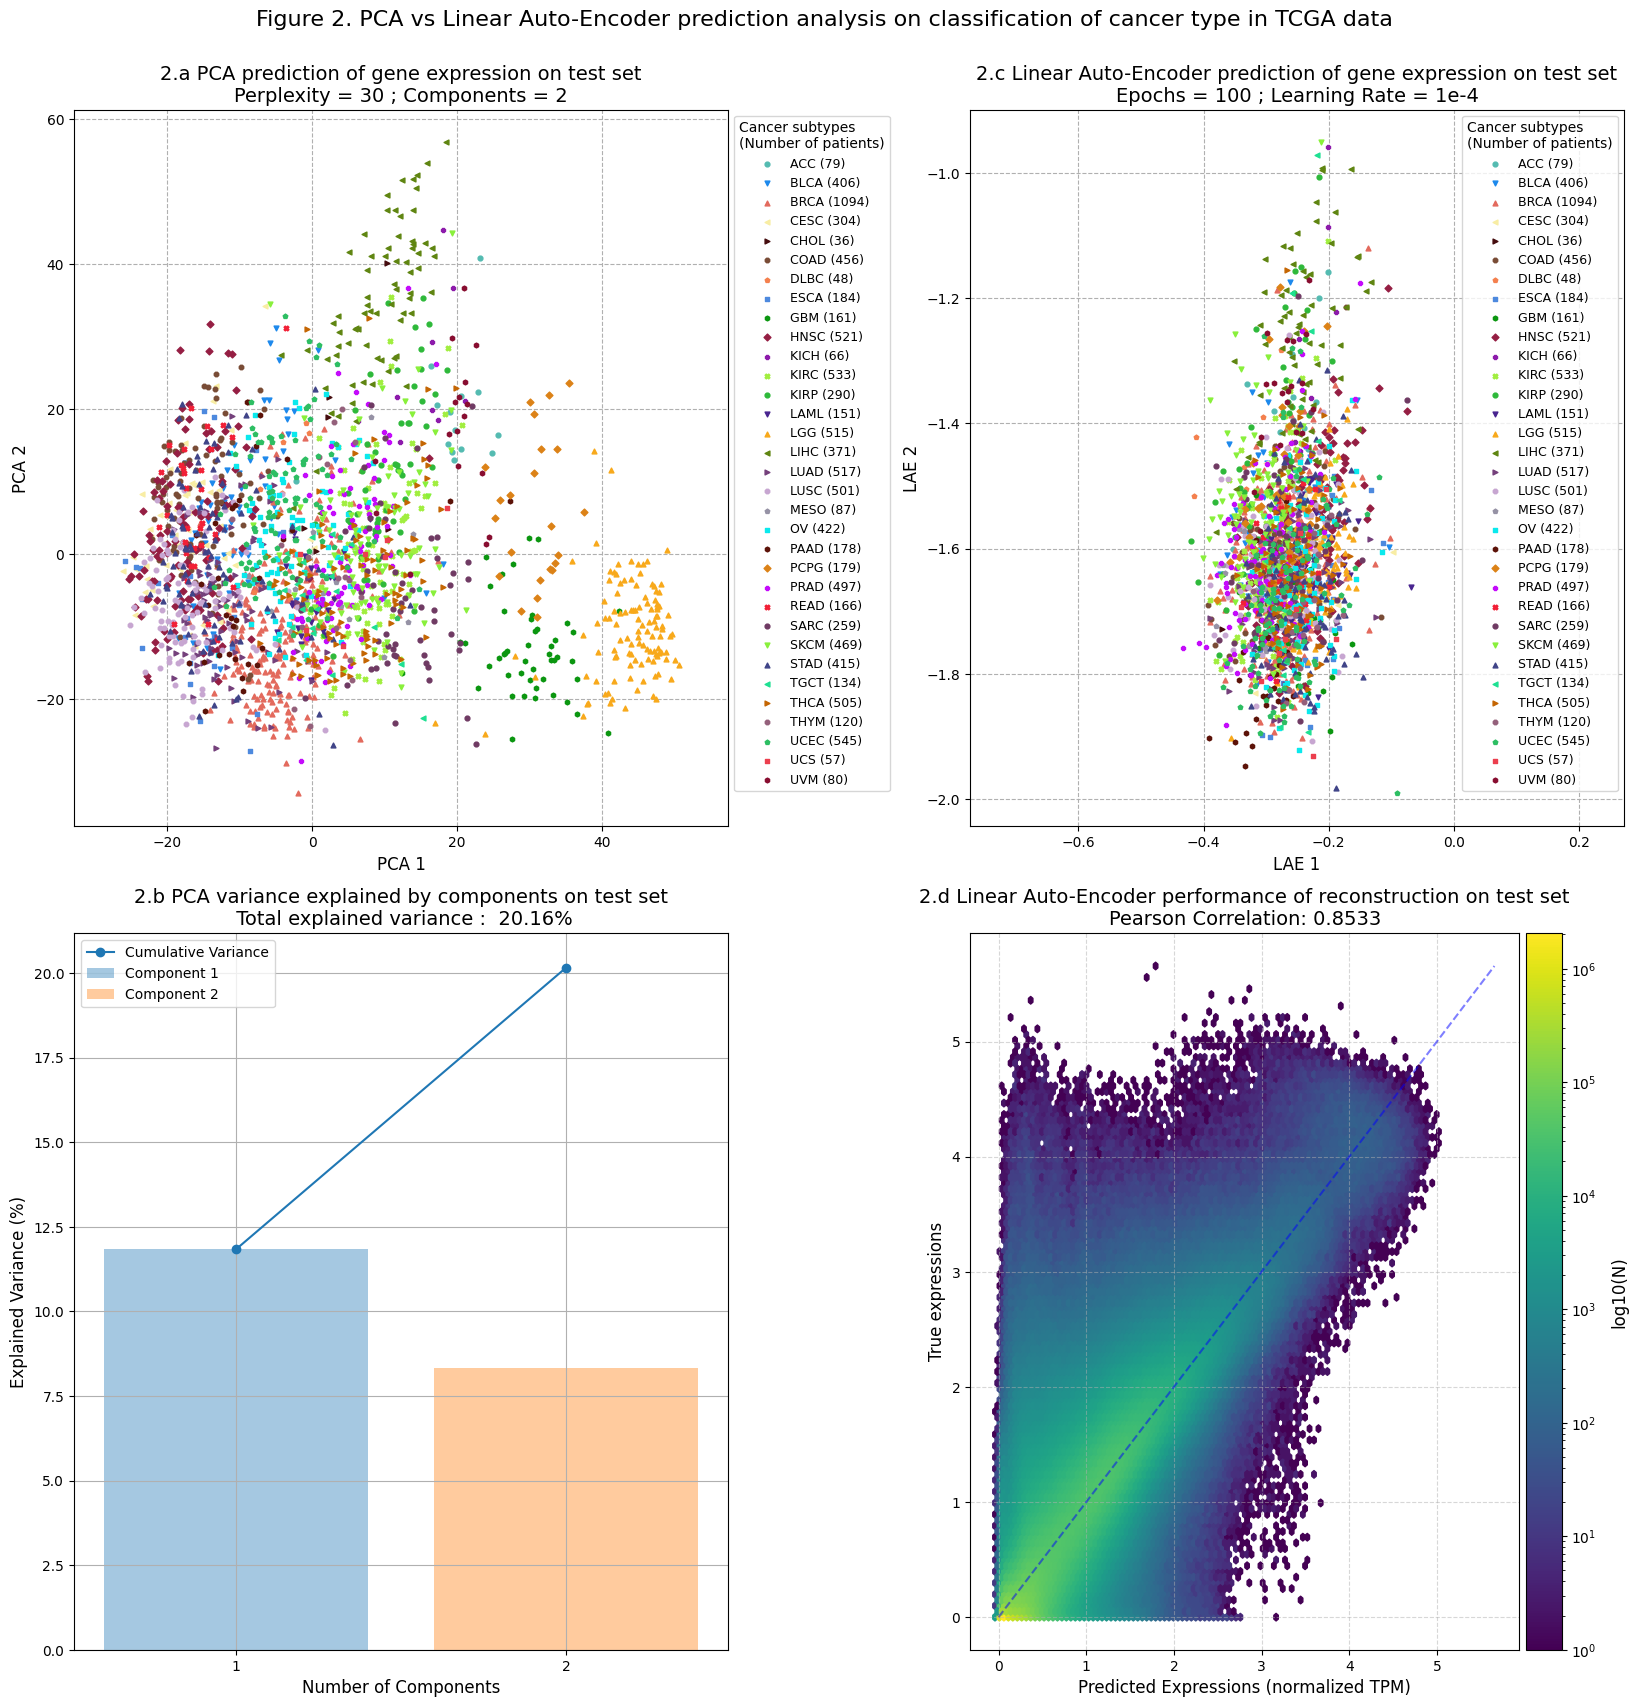

In [374]:
fig.savefig(f'{figures_directory}/pca2d_lae_comparative_analysis_figures.svg', format='svg', bbox_inches='tight')
fig